In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import os
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [5]:
from datasets import load_dataset

# Using the hugging_face Human_vs_Non-human dataset
ds = load_dataset("prithivMLmods/Human-vs-NonHuman")


In [6]:
# Extracting Gradient and orientation information from images

def HOG_features(img):
    r,c= img.shape
    k=3
    filter= np.array([[-1,0,1]])
    edge_horizontal, edge_vertical=[],[]

    for i in range(0, r):
        for j in range(0,c):
            img_window= np.array([img[i,j:j+k]])
            if img_window.shape[1]!=k:
                continue
            edge= filter.dot(img_window.T)
            edge_horizontal.append(edge)

    for i in range(0,r):
        for j in range(0,c):
            img_window= np.array([img[i:i+k, j]])
            if img_window.shape[1]!=k:
                continue
            edge= filter.dot(img_window.T)
            edge_vertical.append(edge)


    edge_horizontal= np.array(edge_horizontal).reshape(r,c-k+1)[0:-2]
    edge_vertical= np.array(edge_vertical).reshape(r-k+1,c)[:,0:-2]

    edge_mag= np.sqrt(edge_horizontal**2+ edge_vertical**2)
    edge_angles=np.rad2deg(np.arctan2(edge_vertical, edge_horizontal))%180

    return [edge_mag, edge_angles]

ds= ds['train']

In [7]:

ds_small= ds.shuffle(seed=42).select(range(500))

img_set, labels_set= [],[]

# Resizing images for size adjustments
for i in range(0, len(ds_small)):
    img= np.array(ds_small[i]['image'])
    img= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img= cv2.resize(img, (200,200))
    labels= int(ds_small[i]['label'])
    img_set.append(img)
    labels_set.append(labels)


# Windows of histogram of oriented gradients

def img_setup(img_list):
    features=[]
    for index in range(0, len(img_list)):
        img= img_list[index]
        r,c= img.shape
        k=8
        HOG=[]

        for i in range(0,r,k):
            for j in range(0,c,k):
                img_window= img[i:i+k, j:j+k]
                r_w, c_w= img_window.shape
                if(r_w !=k or c_w!=k):
                    continue
                edge_mag, edge_angles= HOG_features(img_window)

                bins= np.linspace(0,180,10)
                edge_angles, edge_mag= edge_angles.flatten(), edge_mag.flatten()
                HOG_arr=np.zeros(9)

                for z in range(0, len(edge_angles)):
                    edge_val= math.floor(edge_angles[z]/20)
                    HOG_arr[edge_val]+= edge_mag[z]
                HOG.append(HOG_arr)
        HOG= np.array(HOG)
        features.append(HOG.flatten())

    features= np.array(features)
    return features

features= img_setup(img_set)

Human HOG 0


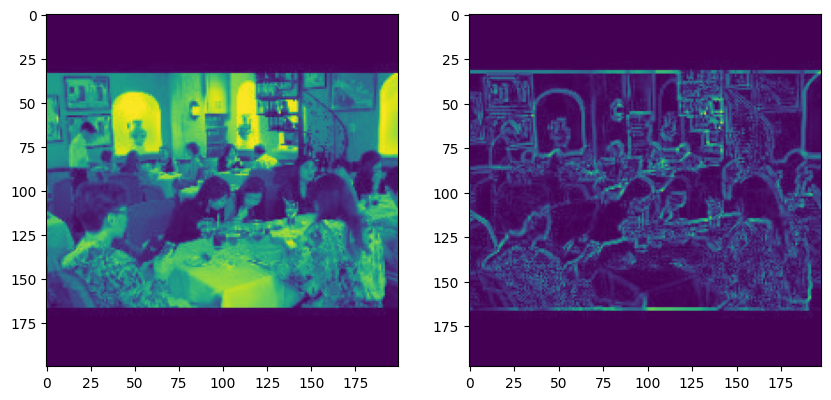

Non Human HOG 1


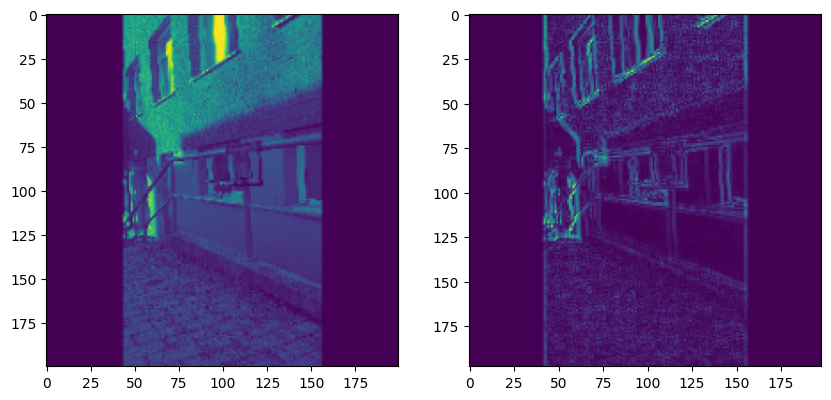

In [9]:
index=8

edge_mag, edge_angles= HOG_features(img_set[index])
print('Human HOG',labels_set[index])
fig,ax= plt.subplots(ncols=2, figsize=[10,5])
ax[0].imshow(img_set[index])
ax[1].imshow(edge_mag)
plt.show()
index=2
edge_mag, edge_angles= HOG_features(img_set[index])
print('Non Human HOG',labels_set[index])
fig,ax= plt.subplots(ncols=2, figsize=[10,5])
ax[0].imshow(img_set[index])
ax[1].imshow(edge_mag)


In [10]:
# Training and Validation test sets
X_train, X_test, y_train, y_test= train_test_split(features, labels_set, shuffle= True, test_size=0.2)



In [14]:
# Using a set of different models

model= [svm.SVC(), RandomForestClassifier(), LogisticRegression()]
model_name=['SVM','Random Forest','Logistic Regression']
for i in range(0, len(model_name)):

    Model=model[i].fit(X_train, y_train)
    y_pred= Model.predict(X_test)

    acc=accuracy_score(y_test, y_pred)
    cm= confusion_matrix(y_test, y_pred)
    print('Accuracy score for', model_name[i], acc)
    print('Confusion matrix for', model_name[i], cm)
    print()


Accuracy score for SVM 0.88
Confusion matrix for SVM [[42  3]
 [ 9 46]]

Accuracy score for Random Forest 0.84
Confusion matrix for Random Forest [[38  7]
 [ 9 46]]

Accuracy score for Logistic Regression 0.81
Confusion matrix for Logistic Regression [[35 10]
 [ 9 46]]

